**NN Classifier Implementation**
----------------------------------
__________________________________

1. [Data Preprocessing](#Data-Preprocessing)
2. [Data Description](#Data-Description)
3. [Model Implementation](#Model-Implementation)
4. [Model Evaluation](#Model-Evaluation)

In [12]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [13]:
def preprocess(sequences, embeddings, maxlen=12):
    pad_emb = np.zeros(embeddings[next(iter(embeddings))].shape)
    processed_sequences = []
    for sequence in sequences:
        word_embeddings = []
        for word in sequence.split()[:maxlen]:
            word_embeddings.append(embeddings.get(word, pad_emb))
        while len(word_embeddings) < maxlen:
            word_embeddings.append(pad_emb)
        processed_sequences.append(np.array(word_embeddings))
    return np.array(processed_sequences)

def load_embeddings(file_path='embeddings.npy'):
    return np.load(file_path, allow_pickle=True).item()

def stats(corpus):
    tokens = [word for sentence in corpus for word in sentence.split()]
    vocab = {word: idx for idx, word in enumerate(set(tokens))}
    return vocab, tokens

embeds = load_embeddings()
file = pd.read_csv('dataset/email_spam_augp.csv')
sequences, labels = file.email.values, file.label.values 
features = preprocess(sequences, embeds, 12)
vocab, tokens = stats(sequences)
classes = np.unique(labels)
print("Tokens:",len(tokens))
print("Vocab:",len(vocab))
print("Seqs:",len(file))
file

Tokens: 411988
Vocab: 26301
Seqs: 3038


,email,label
0,date wed number aug number number number numbe...,0
1,martin posted tasso papadopoulos greek sculpto...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,adding cream spaghetti carbonara effect pasta ...,0
...,...,...
3033,telephone number telephone number telephone nu...,1
3034,attn sir madan strictly confidential happy int...,1
3035,thank shopping gift occasion free gift number ...,1
3036,ebay ebay ebay ebay ebay ebay ebay ebay ebay e...,1


## Data Description

In [14]:
# Function to split classified data into train and test sets
def train_test_split(X, y, seqs, test_size=0.2, random_state=None):
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(len(X))  # Shuffle indices
    split_index = int(len(X) * (1 - test_size))  # Determine split point

    # Split into training and testing sets
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    return  X[train_indices], y[train_indices], \
    X[test_indices], y[test_indices], seqs[test_indices]

np.random.seed(0)
# Mean Normalization of Input Data
def normalizeInput(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1
    return (data - mean) / std

# Function to calculate the class (positive/negative) weights
def calculate_class_weights(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    class_weights = total_samples / (len(unique)*counts)
    return dict(zip(unique, class_weights))

# Function to seperate the data into labels (positive/negative) with their sequences
def classify_data(file_data):
    class_sequences = {}
    for seq, label in file_data:  # Iterate through each sequence and its label
        if label not in class_sequences:
            class_sequences[label] = [] # Initialize list for each label
        class_sequences[label].append(seq)  # Add sequence to its label category
    return class_sequences

# Display data distribution by class
def show_data_distribution(data, cls):
    dataset = [(data[i], cls[i]) for i in range(cls.shape[0])]
    dataset = classify_data(dataset)
    for key, values in dataset.items():
        print(f"{key}: {len(values)}")

X_train, y_train, X_test, y_test, seqs = train_test_split(features, labels, sequences, test_size=0.2)
X_train = normalizeInput(X_train)
X_test = normalizeInput(X_test)

print("Train Features:", X_train.shape)
print("Train Labels:", y_train.shape)
print("Test Features:", X_test.shape)
print("Test Labels:", y_test.shape)

print("\nTrain Distribution:")
show_data_distribution(X_train, y_train)

print("Test Distribution:")
show_data_distribution(X_test, y_test)

print("\nClass Weights:")
class_weights = calculate_class_weights(y_train)
for key, values in class_weights.items():
    print(f"{key}: {values:.4f}")

Train Features: (2430, 12, 10)
Train Labels: (2430,)
Test Features: (608, 12, 10)
Test Labels: (608,)

Train Distribution:
0: 1949
1: 481
Test Distribution:
0: 494
1: 114

Class Weights:
0: 0.6234
1: 2.5260


## Model Implementation

In [ ]:
class SpamClassifier():
    """A binary classification neural network using a single hidden layer."""

    def __init__(self, input_size=12, embed_size=10, hidden_size=8, hidden_units=2, output_size=1, std=0.1):
        """Initializes the SpamClassifier with the specified architecture."""
        input_size = input_size * embed_size
        hidden_size = hidden_size * hidden_units
        self.weights1 = np.random.randn(input_size, hidden_size) * std
        self.weights2 = np.random.randn(hidden_size, output_size) * std
        self.bias1 = np.zeros(hidden_size)
        self.bias2 = np.zeros(output_size)

    def sigmoid(self, x):
        """Computes the sigmoid activation function."""
        return 1/(1 + np.exp(-x))
    
    def diff_sigmoid(self, x):
        """Computes the derivative of the sigmoid activation function."""
        return self.sigmoid(x) * (1- self.sigmoid(x))
    
    def forward(self, X):
        """Performs a forward pass through the network."""
        self.cache = {}
        self.cache['z1'] = np.dot(X, self.weights1) + self.bias1    # Weighted sum for hidden layer
        self.cache['a1'] = A = self.sigmoid(self.cache['z1'])       # Activation of hidden layer
        self.cache['z2'] = np.dot(A, self.weights2) + self.bias2    # Weighted sum for output layer
        self.cache['a2'] = self.sigmoid(self.cache['z2'])           # Activation of output layer
        return self.cache['a2']  # Return output
        
    def backward(self, X, y, alpha=0.01):
        """Performs backpropagation and updates the network parameters."""
        batch_size = X.shape[0]
        dz2 = self.cache['a2'] - y  # Gradient for output layer
        dw2 = np.dot(self.cache['a1'].T, dz2) / batch_size  # Gradient for weights between hidden and output layer
        db2 = np.sum(dz2, axis=0) / batch_size  # Gradient for output bias
        
        da1 = np.dot(dz2, self.weights2.T)  # Gradient for hidden layer activations
        dz1 = da1 * self.diff_sigmoid(self.cache['z1'])  # Gradient for hidden layer pre-activations
        dw1 = np.dot(X.T, dz1) / batch_size  # Gradient for weights between input and hidden layer
        db1 = np.sum(dz1, axis=0) / batch_size  # Gradient for hidden bias

        # Update parameters using gradients
        self.weights2 -= alpha * dw2
        self.weights1 -= alpha * dw1
        self.bias2 -= alpha * db2
        self.bias1 -= alpha * db1

    def bce_loss(self, y, y_hat, class_weights=None):
        """Computes the binary cross-entropy loss."""
        if class_weights is None: return -np.mean(y * np.log(y_hat + 1e-8) + (1 - y) * np.log( 1 - y_hat + 1e-8))     
        return -np.mean(class_weights[1] * y * np.log(y_hat + 1e-8) + class_weights[0] * (1 - y) * np.log(1 - y_hat + 1e-8))
        
    def train(self, X, y, Xt, yt, learning_rate=0.01, epochs=100, class_weights=None):
        """Trains the SpamClassifier using the given training data."""
        Xt, yt = Xt.reshape(Xt.shape[0], -1), yt.reshape(-1, 1)
        X, y = X.reshape(X.shape[0], -1), y.reshape(-1, 1)
        history = {'train':{}, 'val':{}}

        for epoch in range(epochs):
            outputs = self.forward(X)                           # Perform Forward Pass
            loss = self.bce_loss(y, outputs, class_weights)     # Compute Binary Cross Entropy Loss
            self.backward(X, y, learning_rate)                  # Perform Backward Pass & Update Weights

            # Log progress every 5% of total epochs
            if epoch % (epochs//20) == 0: 
                train_acc = self.accuracy(y, outputs)
                val_acc = self.accuracy(yt, self.forward(Xt))
                val_loss = self.bce_loss(yt, self.forward(Xt))
                print(f"Epoch {epoch+1}/{epochs} - loss {loss:.4f} - accuracy {train_acc:.4f} - val_loss {val_loss:.4f} - val_accuracy {val_acc:.4f}")
                history['train'][epoch] = train_acc; history['val'][epoch] = val_acc
        return history

    def predict(self, X, thresh=0.5):
        """Predicts the class labels for the given input data."""
        X = X.reshape(X.shape[0], -1)
        output = self.forward(X)
        return (output >= thresh).astype(int)
    
    def accuracy(self, y, outputs, thresh=0.5):
        """Calculates accuracy of predictions against true labels."""
        y_preds = (outputs >= thresh).astype(int)
        return np.mean(y_preds == y)
    
# Create a Classifier for Email Spam Detection
classifier = SpamClassifier()

Epoch 1/15000 - loss 0.6942 - accuracy 0.8021 - val_loss 0.6204 - val_accuracy 0.8125
Epoch 751/15000 - loss 0.6224 - accuracy 0.8177 - val_loss 0.3247 - val_accuracy 0.8289
Epoch 1501/15000 - loss 0.4637 - accuracy 0.8798 - val_loss 0.2600 - val_accuracy 0.8799
Epoch 2251/15000 - loss 0.4056 - accuracy 0.8934 - val_loss 0.2431 - val_accuracy 0.9030
Epoch 3001/15000 - loss 0.3770 - accuracy 0.8963 - val_loss 0.2372 - val_accuracy 0.9013
Epoch 3751/15000 - loss 0.3582 - accuracy 0.9029 - val_loss 0.2337 - val_accuracy 0.8997
Epoch 4501/15000 - loss 0.3428 - accuracy 0.9066 - val_loss 0.2307 - val_accuracy 0.9046
Epoch 5251/15000 - loss 0.3287 - accuracy 0.9107 - val_loss 0.2278 - val_accuracy 0.9030
Epoch 6001/15000 - loss 0.3148 - accuracy 0.9152 - val_loss 0.2250 - val_accuracy 0.9079
Epoch 6751/15000 - loss 0.3011 - accuracy 0.9189 - val_loss 0.2223 - val_accuracy 0.9079
Epoch 7501/15000 - loss 0.2873 - accuracy 0.9263 - val_loss 0.2197 - val_accuracy 0.9079
Epoch 8251/15000 - loss 0

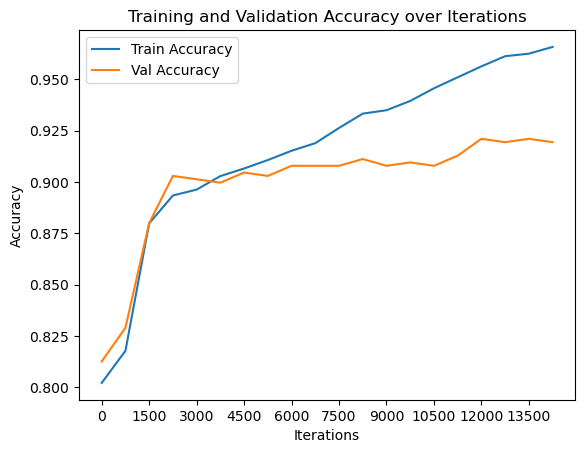

In [16]:
# Train the CLassifier Neural Network
history = classifier.train(X_train, y_train, X_test, y_test, learning_rate=0.05, epochs=15000, class_weights=class_weights)

# Plot accuracy over iterations
for key, values in history.items():
    iterations = list(values.keys())
    accuracies = list(values.values())
    plt.plot(iterations, accuracies, label=f'{key.capitalize()} Accuracy')
    
plt.title('Training and Validation Accuracy over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.xticks(list(history['train'].keys())[::2])
plt.legend()
plt.show()

## Model Evaluation

True Distribution: {0: 494, 1: 114}
Pred Distribution: {0: 496, 1: 112}
True Positives: 471
True Negatives: 89
False Positives: 25
False Negatives: 23

Recall: 0.9534
AUC-ROC: 0.2193
Specificity: 0.7807
Precision: 0.9496
F1 score: 0.9515
Accuracy: 0.9211


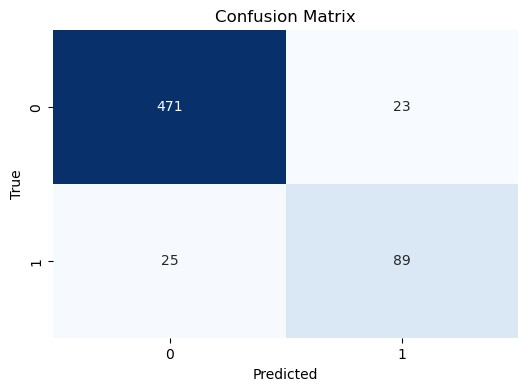

In [ ]:
# Build confusion matrix from true and predicted labels
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for y_true, y_pred in zip(y_true, y_pred):
        matrix[y_true][y_pred] += 1
    return matrix

# Calculate class distribution based on confusion matrix
def distribution(matrix, classes, actual=True):
    distribution = {}; counts = [0]*len(classes)
    for i in range(len(classes)):
        if actual == True: counts[i] = sum(matrix[i])
        else: counts[i] = sum(matrix[j][i] for j in range(len(classes)))
    for i, cls in enumerate(classes):
        distribution[cls] = counts[i]
    return distribution

# Print statistics based on the confusion matrix
def describe_stats(matrix):
    (Tp, Fn), (Fp, Tn) = matrix
    print("True Positives:", Tp)
    print("True Negatives:", Tn)
    print("False Positives:", Fp)
    print("False Negatives:", Fn)

    recall = Tp/(Tp+Fn)
    precision = Tp/(Tp+Fp)
    f1 = 2*(precision*recall)/(precision+recall)
    print(f"\nRecall: {Tp/(Tp+Fn):.4f}")
    print(f"AUC-ROC: {Fp/(Fp+Tn):.4f}")
    print(f"Specificity: {Tn/(Tn+Fp):.4f}")
    print(f"Precision: {Tp/(Tp+Fp):.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"Accuracy: {(Tp+Tn)/(Tp+Tn+Fp+Fn):.4f}")

y_true = y_test
X_test = X_test.reshape(X_test.shape[0], -1)
y_pred = classifier.predict(X_test).reshape(-1)
matrix = confusion_matrix(y_true, y_pred, len(classes))
print("True Distribution:", distribution(matrix, classes))
print("Pred Distribution:", distribution(matrix, classes, False))
describe_stats(matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()